# Wasserstein GAN (WGAN)

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

## Dataset: lsun bedrooms

In [2]:
PATH = Path('data/lsun/')
IMG_PATH = PATH/'bedrooms'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [3]:
TMP_PATH.mkdir(exist_ok=True)

In [4]:
files = PATH.glob('bedrooms/**/*.jpg')

In [5]:
with CSV_PATH.open('w') as out:
    for f in files:
        out.write(f'{f.relative_to(IMG_PATH)},0\n')
        
# The 0 is a fake label so that we can utilize existing dataset and dataloader objects

# Note: for experimenting its useful to create a small subset of the dataset. Simply do `if random.random()<0.1: out.write...`

In [6]:
bs=128
sz=64
nz=100

In [7]:
tfms = tfms_from_stats(inception_stats, sz)

In [8]:
modeldata = ImageClassifierData.from_csv(PATH, 'bedrooms', CSV_PATH, tfms=tfms, bs=bs, skip_header=False, continuous=True)

In [21]:
modeldata = modeldata.resize(128)

In [26]:
x, _ = next(iter(modeldata.val_dl))

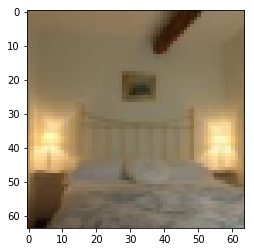

In [27]:
plt.imshow(modeldata.trn_ds.denorm(x)[6])

## Architecture

In [11]:
class ConvLayer(nn.Module):
    def __init__(self, n_in, n_out, kernel_size, stride, bn=True, pad=None):
        super().__init__()
        
        if pad is None: pad = kernel_size//2//stride
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(n_out) if bn else None
        self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.leakyRelu(self.conv(x))
        return self.bn(x) if self.bn else x

### Discriminator

Gives a single number that says whether it believes the image is real or fake

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_size, n_in, n_out, n_extra_layers=0):
        super().__init__()
        assert in_size % 16 == 0
        
        self.conv1 = ConvLayer(n_in, n_out, 4, 2, bn=False)
        csize = in_size/2
        cndf  = n_out
        
        self.extra = nn.Sequential(*[ConvLayer(cndf, cndf, 3, 1) for t in range(n_extra_layers)])  # preserve size
        
        pyramid_layers = []
        
        while csize > 4:  # until height or width is <= 4
            pyramid_layers.append(ConvLayer(cndf, cndf * 2, 4, 2))
            cndf *= 2
            csize /= 2
        
        self.pyramid = nn.Sequential(*pyramid_layers)
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        
    def forward(self, x):
        #pdb.set_trace()
        x = self.conv1(x)
        x = self.extra(x)
        x = self.pyramid(x) # [128, 512, 4, 4] for 64x64 input
        x = self.final(x)   # [128, 1, 1, 1] for 64x64 input, now do mean over batch
        x = x.mean(0).view(1) # torch.Size([1])
        return x

### Generator

In [13]:
class DeconvLayer(nn.Module):
    def __init__(self, n_in, n_out, kernel_size, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_in, n_out, kernel_size, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(n_out) if bn else None
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [61]:
class Generator(nn.Module):
    def __init__(self, in_size, nz, n_c, ngf, n_extra_layers=0):
        super().__init__()
        assert in_size % 16 == 0

        cngf = ngf //2  # cngf=32 assuming ngf=64
        tisize = 4
        # input tensor (noise) has shape (bs, 100, 1, 1)
        while tisize != in_size:
            tisize *= 2
            cngf *= 2
        # cngf is i.e. 512 here if starting with n_out=64
        
        layers = [DeconvLayer(nz, cngf, 4, 1, 0)]
        csize = 4  # because shape of noise was (bs, 100, 1, 1) and after transposed conv it is (bs, 512, 4, 4)

        while csize < in_size//2:
            layers.append(DeconvLayer(cngf, cngf//2, 4, 2, 1))
            cngf //= 2
            csize *= 2
        #pdb.set_trace()
        # here cngf = 64 (was 512), csize = 32
        layers += [DeconvLayer(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]  # do not change size
        layers.append(nn.ConvTranspose2d(cngf, n_c, 4, 2, 1, bias=False))  
        # (64, 32, 32) -> (3, 64, 64) (stride 2 deconv)
        self.features = nn.Sequential(*layers)
       
    def forward(self, input):
        return F.tanh(self.features(input))  # normalized imgs have mean of 0 -> tanh
             
# Takes input (noise) of shape (bs, 100, 1, 1) and converts it to (bs, 3, 64, 64) throug a series of transposed convs

In [118]:
netG = Generator(sz, nz, 3, 64, 1)
netD = Discriminator(sz, 3, 64, 1)

In [119]:
netG.cuda()
netD.cuda()

Discriminator(
  (conv1): ConvLayer(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (leakyRelu): LeakyReLU(negative_slope=0.2, inplace)
  )
  (extra): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyRelu): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (pyramid): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyRelu): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): ConvLayer(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyRelu)

### Let's create some noise as input for the Generator

In [120]:
def gen_noise(bs):
    return V(torch.zeros(bs, nz, 1, 1).normal_(0,1))

In [121]:
noise = gen_noise(4).cuda()
preds = netG(noise)
preds_denom = modeldata.trn_ds.denorm(preds)

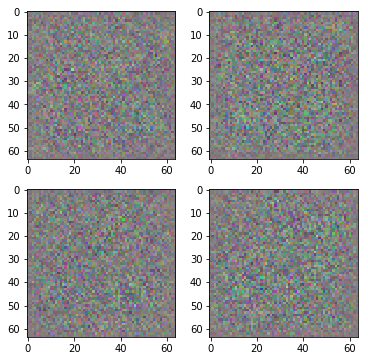

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(preds_denom[i])

## Train

In [123]:
def train(n_iter, first=True):
    gen_iterations = 0
    for epoch in trange(n_iter):  # trange resets the progress bar when necessary
        netD.train() # bring both nets into training mode
        netG.train() 
        data_iter = iter(modeldata.trn_dl)
        i, n = 0, len(modeldata.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:  # for all batches in epoch
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and gen_iterations<25) or (gen_iterations % 500 == 0) else 5
                
                j = 0
                while (j < d_iters) and (i < n):  # for all j in discriminator iterations
                    j += 1; i += 1
                    for p in netD.parameters():
                        p.data.clamp_(-0.01, 0.01)  # this makes it a Wasserstein GAN
                    real = V(next(data_iter)[0])
                    fake = netG(gen_noise(real.size(0)))
                    
                    # Loss
                    real_loss = netD(real)
                    fake_loss = netD(V(fake.data))  # so gradients to flow to generator
                    lossDiscr = real_loss - fake_loss
                    # real = 0 and false = 1
                    # if disc is good it says 0 - 1 = -1
                    # if disc is bad it says  1 - 0 = 1
                    netD.zero_grad()
                    lossDiscr.backward()  # calc gradients
                    optimizerD.step()
                    pbar.update()
                        
                # Train the generator
                set_trainable(netD, False)
                set_trainable(netG, True)
                
                netG.zero_grad()
                lossGen = netD(netG(gen_noise(bs))).mean(0).view(1)  
                # gradient flows back through generator (as opposed to netD(V(fake.data)))
                # discr says 0 means it thinks its real. The lower lossG, the better for the Gen
                lossGen.backward()
                optimizerG.step()
                gen_iterations += 1
        
        print(f'Loss_D {to_np(lossDiscr)}; Loss_G {to_np(lossGen)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')                                     

In [124]:
torch.backends.cudnn.benchmark=True

In [125]:
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-4)
set_trainable(netD, True)
set_trainable(netG, True)
train(5, False)

100%|██████████| 1895/1895 [01:46<00:00, 17.84it/s]
Loss_D [-0.77959]; Loss_G [0.65134]; D_real [-0.62345]; Loss_D_fake [0.15614]
100%|██████████| 1895/1895 [01:46<00:00, 17.80it/s]
Loss_D [-0.76487]; Loss_G [0.6469]; D_real [-0.65841]; Loss_D_fake [0.10646]
100%|██████████| 1895/1895 [01:46<00:00, 17.79it/s]
Loss_D [-0.61264]; Loss_G [0.67364]; D_real [-0.62199]; Loss_D_fake [-0.00935]
100%|██████████| 1895/1895 [01:47<00:00, 17.70it/s]
Loss_D [-0.72617]; Loss_G [0.61039]; D_real [-0.55825]; Loss_D_fake [0.16793]
100%|██████████| 1895/1895 [01:47<00:00, 17.71it/s]
Loss_D [-0.62614]; Loss_G [0.56204]; D_real [-0.51388]; Loss_D_fake [0.11225]
100%|██████████| 5/5 [08:53<00:00, 106.71s/it]

In [126]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [127]:
fixed_noise = gen_noise(bs)

In [128]:
netD.eval()
netG.eval()
fake = netG(fixed_noise).data.cpu()
fake = np.clip(modeldata.trn_ds.denorm(fake), 0, 1)

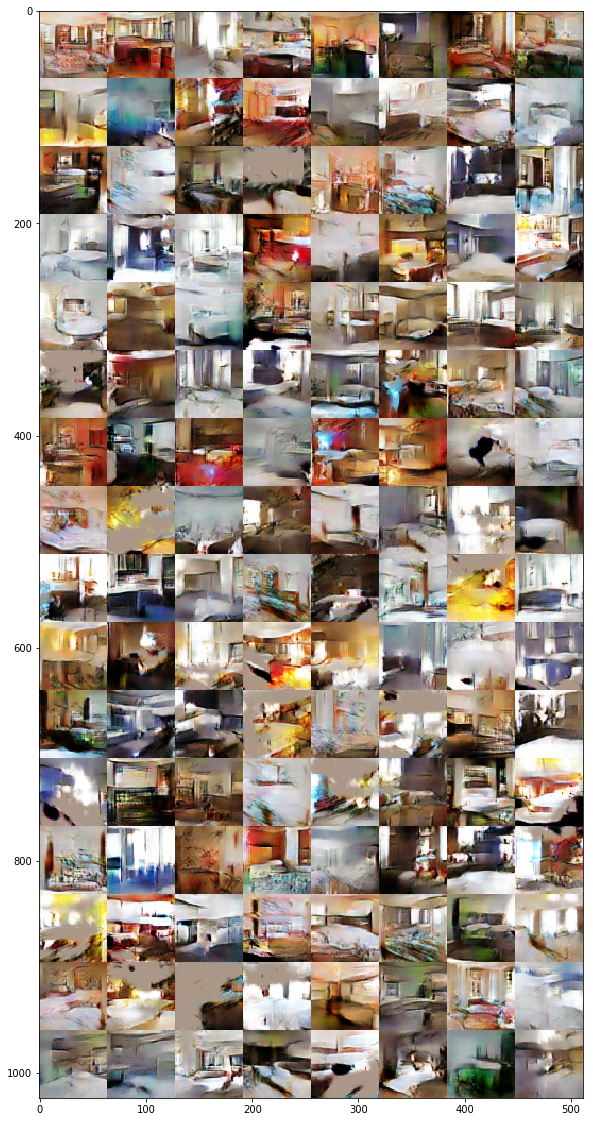

In [129]:
plt.figure(figsize=(20,20))
plt.imshow(gallery(fake, 8))

#### Let's train some more

In [131]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-5)
train(5, False)

100%|██████████| 1895/1895 [01:46<00:00, 17.83it/s]
Loss_D [-0.98182]; Loss_G [0.51567]; D_real [-0.50069]; Loss_D_fake [0.48113]
100%|██████████| 1895/1895 [01:47<00:00, 17.71it/s]
Loss_D [-1.0118]; Loss_G [0.47511]; D_real [-0.4639]; Loss_D_fake [0.5479]
100%|██████████| 1895/1895 [01:47<00:00, 17.70it/s]
Loss_D [-0.98237]; Loss_G [0.43749]; D_real [-0.45281]; Loss_D_fake [0.52956]
100%|██████████| 1895/1895 [01:47<00:00, 17.60it/s]
Loss_D [-1.01526]; Loss_G [0.52871]; D_real [-0.52494]; Loss_D_fake [0.49032]
100%|██████████| 1895/1895 [01:47<00:00, 17.71it/s]
Loss_D [-0.98513]; Loss_G [0.50287]; D_real [-0.45572]; Loss_D_fake [0.52942]
100%|██████████| 5/5 [08:55<00:00, 107.06s/it]

In [132]:
netD.eval()
netG.eval()
fake = netG(fixed_noise).data.cpu()
fake = np.clip(modeldata.trn_ds.denorm(fake), 0, 1)

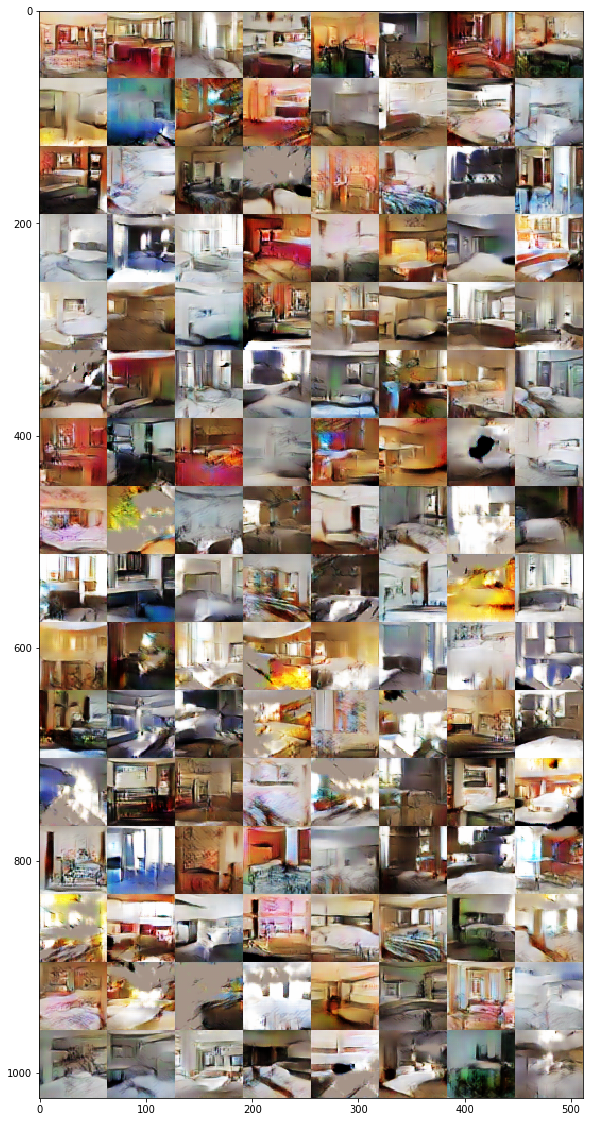

In [133]:
plt.figure(figsize=(20,20))
plt.imshow(gallery(fake, 8))